In [1]:
from langchain import OpenAI
from langchain.agents import AgentType, initialize_agent
from langchain.agents import Tool, tool
from langchain import agents
import langchain
import os
import requests
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import sys


from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFLoader
from langchain_openai import ChatOpenAI

from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
Embedding_model = 'text-embedding-ada-002' 

from langchain.text_splitter import CharacterTextSplitter


In [40]:
## This model based on this paper: https://pubs.acs.org/doi/10.1021/acs.jcim.1c01334
## And is coming from this URL 
## https://github.com/dockstring/dockstring/tree/main
## Also see https://github.com/dockstring/dockstring/blob/main/dockstring/target.py#L160

from dockstring import load_target

@tool
def predict_docking_score(smiles):
    '''
    This tool predicts the docking score to DRD2 for a SMILES molecule. Lower docking score means a larger binding affinity. 
    '''
    target = load_target("DRD2")
    try:
        score, affinities = target.dock(smiles)
    except:
        score = 'Invalid molecule'
    return score

# score = predict_docking_score("CC1=C(C(=O)N2CCCCC2=N1)CCN3CCC(CC3)C4=NOC5=C4C=CC(=C5)F")

In [41]:
from langchain.memory import ConversationBufferMemory

RetrievalQA_prompt = """What are the design guidelines for making a molecule have a larger binding afinity against DRD2 (dopamine D2 subtype receptor) target? 
    This can be based on making changes to the functional groups or other changes to the molecule. Summarize answer"""
def RetrievalQABypassTokenLimit(vector_store, RetrievalQA_prompt, llm, k=10, fetch_k=50, min_k=4, chain_type="stuff"):
    while k >= min_k:
            try:
                retriever = vector_store.as_retriever(
                    search_type="mmr",
                    search_kwargs={"k": k, "fetch_k": fetch_k},
                )
                qa_chain = RetrievalQA.from_chain_type(
                    llm=llm,
                    chain_type=chain_type,
                    retriever=retriever,
                    memory=ConversationBufferMemory(
                            ))
                
                # Check to see if we hit the token limit
                result = qa_chain.run({"query": RetrievalQA_prompt})
                return result  # If successful, return the result and exit the function
    
            except Exception as e:
                # If an error is caught, reduce the value of k and retry
                # print(e)
                print(
                    f"\nk={k} results hitting the token limit for the chosen LLM. Reducing k and retrying...\n"
                )
                k -= 1

@tool
def lookup_papers(prompt):
    '''This tool looks up design guidelines for molecules with higher binding afinity against DRD2 by looking through research papers.
    '''
    guide_lines = []
    for m in range(1):
        text_splitter = CharacterTextSplitter(
            chunk_size=500, chunk_overlap=20)
        paper_file =f'../data/papers/Binding/{m}.pdf'
        pages = PyPDFLoader(paper_file).load_and_split()
        sliced_pages = text_splitter.split_documents(pages)
        faiss_vectorstore = FAISS.from_documents(sliced_pages, OpenAIEmbeddings(model=Embedding_model))
        
        llm=ChatOpenAI(
                        model_name='gpt-4o',
                        temperature=0.1,
                        )
        g = RetrievalQABypassTokenLimit(faiss_vectorstore, RetrievalQA_prompt, llm)
        guide_lines.append(g)
        # break
    return guide_lines

guidel_lines = lookup_papers("")
guidel_lines

['To design a molecule with a larger binding affinity against the dopamine D2 receptor (DRD2), consider the following guidelines:\n\n1. **Aromatic/heteroaromatic cyclic amine derivatives**: Utilize 1,4-disubstituted aromatic/heteroaromatic cyclic amine derivatives, such as piperazine, homopiperazine, piperidine, or tropane. These structures are commonly associated with high affinity for DRD2.\n\n2. **Lipophilic appendages**: Incorporate various lipophilic appendages to enhance binding affinity. These appendages can interact favorably with the hydrophobic regions of the receptor.\n\n3. **Orthosteric and allosteric sites**: Design bitopic ligands that can simultaneously bind to both orthosteric and allosteric sites. This can improve receptor affinity and selectivity. The orthosteric site is typically targeted by the endogenous ligand (dopamine) and phenylpiperazines, while the allosteric site can be targeted by aromatic/heteroaromatic lipophilic fragments connected via an optimal linker.

In [47]:

@tool
def check_validity(SMILES):
    '''This tool inputs SMILES string representations checks if it is a chemically feasible molecule.
    '''
    from rdkit import Chem
    from rdkit.Chem import Draw
    try:
        mol = Chem.MolFromSmiles(SMILES)
        if mol is None:
            return "Invalid", SMILES
        return "Valid", SMILES
    except Exception as e:
        # return f"An error occurred: {str(e)}"
        return "Invalid", SMILES

tools = [lookup_papers, check_validity, predict_docking_score]

In [48]:
# prompt= ""
# lookup_papers(prompt)

In [51]:
from langchain.agents.structured_chat.base import StructuredChatAgent
from langchain.agents.agent import AgentExecutor
from langchain.agents import AgentType
from langchain.schema import HumanMessage, SystemMessage
from langchain.agents import AgentExecutor, create_openai_functions_agent

message = """You are a helpful Chemist AI assistant. You are tasked to make changes to a molecule and increase its binding affinity DRD2
    Use the tools to get chemical intution and if you don't know, do not make up answers. 
    """

system_message = SystemMessage(
  content=message
)

agent_llm = ChatOpenAI(
                        model_name='gpt-4o',
                        temperature=0.2,
                        max_tokens=4096
                        )

from langchain.agents import initialize_agent
from langchain.memory import ConversationBufferMemory
agent = initialize_agent(
            tools=tools, llm=agent_llm, agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION,
            verbose=True, memory=ConversationBufferMemory(memory_key="chat_history", input_key='input', output_key="output", return_messages=True),
            early_stopping_method='generate', handle_parsing_errors=True, system_message=system_message, prefix=message,
            agent_kwargs = {
                "prefix":message,
        "system_message": system_message,
    }, return_intermediate_steps=True, max_iterations=40
            )



In [52]:
# response = agent_executor.invoke({"input": f"Look up design guidelines and make changes to the MOF [Co].[O-]C(=O)c1ccncc1 so it will have a higher band gap:\
#             After each change you should first check validity of new SMILES, if valid evaluate the band gap, otherwise revert change and try something else.\n\
#             "})

In [53]:
initial_molecule = "CC(=O)OC1=CC=CC=C1C(=O)O" # this is Asprin
question = f"Look up design guidelines and make changes to {initial_molecule} so it will have a higher binding afinity against DRD2 target:\
            Summarize design guidelines\
            Alway evaluate the docking score and then validity of the first input SMILES first\
             After each change you should calculate the docking score and evaluate the the validity of the new molecule. \
            if invalid revert change to the previous valid SMILES and try something else and re-evauate validity.\
             Iterate for 10 new molecule candidates and then stop.\n\
             "
iteration_data = []
iteration = 0
cost = 0
from langchain_community.callbacks import get_openai_callback


for step in agent.iter({"input": question}):
    with get_openai_callback() as cb:
        if output := step.get("intermediate_step"):
            action, value = output[0]
            if action.tool == "predict_docking_score":
                docking_score = value
            if action.tool == "check_validity":
                chemical_feasibility, SMILES = value
                iteration_data.append({
                                        'iteration': iteration,
                                        'data': {
                                            'SMILES': SMILES,
                                            'Chemical Feasibility': chemical_feasibility,
                                            'Docking Score': docking_score,
                                        }
                                    })
                iteration += 1
                # break 
                # assert is_prime(int(value))
            # Ask user if they want to continue
            # _continue = input("Should the agent continue (Y/n)?:\n") or "Y"
            # if _continue.lower() != "y":
            #     break
    cost += cb.total_cost

print(f'Cost: ${cost}')



> Entering new AgentExecutor chain...
```
Thought: Do I need to use a tool? Yes
Action: lookup_papers
Action Input: design guidelines for molecules with higher binding affinity against DRD2
Observation: ['To design a molecule with a larger binding affinity against the dopamine D2 receptor (DRD2), consider the following guidelines based on structural and functional insights:\n\n1. **Aromatic/heteroaromatic cyclic amine derivatives**: Utilize 1,4-disubstituted aromatic/heteroaromatic cyclic amine groups, such as piperazine, homopiperazine, piperidine, or tropane. These structures are commonly found in high-affinity DRD2 ligands.\n\n2. **Aromatic head group**: The aromatic head group controls intrinsic activity. Ensure it is capable of forming strong interactions with the receptor.\n\n3. **Amine moiety**: Incorporate an amine moiety that can form a hydrogen bond with the crucial residue Asp3.32 in the transmembrane helix 3 of DRD2. This interaction is essential for stabilizing the ligan

[12:57:44] SMILES Parse Error: syntax error while parsing: CC(=O)OC1=CC=CC=C1C(=O)N2CCN(CC2N)CC3=CC=CC=C3CC4=CC=CC(C(OH))=C4
[12:57:44] SMILES Parse Error: Failed parsing SMILES 'CC(=O)OC1=CC=CC=C1C(=O)N2CCN(CC2N)CC3=CC=CC=C3CC4=CC=CC(C(OH))=C4' for input: 'CC(=O)OC1=CC=CC=C1C(=O)N2CCN(CC2N)CC3=CC=CC=C3CC4=CC=CC(C(OH))=C4'


The modified molecule with a hydroxyl group added to the piperazine ring is invalid. Therefore, we will revert to the previous valid SMILES and conclude our iterations.

### Summary of Candidates:
1. **Initial Molecule**: CC(=O)OC1=CC=CC=C1C(=O)O - Docking Score: -6.2
2. **Candidate 1**: CC(=O)OC1=CC=CC=C1C(=O)N2CCNCC2 - Docking Score: -6.8
3. **Candidate 2**: CC(=O)OC1=CC=CC=C1C(=O)N2CCNCC2N - Docking Score: -7.2
4. **Candidate 3**: CC(=O)OC1=CC=CC=C1C(=O)N2CCN(CC2)CCC - Docking Score: -6.5 (Reverted)
5. **Candidate 4**: CC(=O)OC1=CC=CC=C1C(=O)N2CCN(CC2N)C - Docking Score: -7.5
6. **Candidate 5**: CC(=O)OC1=CC=CC=C1C(=O)N2CCN(CC2N)CC3=CC=CC=C3 - Docking Score: -8.7
7. **Candidate 6**: CC(=O)OC1=CC=CC=C1C(=O)N2CCN(CC2N)CC3=CC=CC=C3CC4=CC=CC=C4 - Docking Score: -9.2
8. **Candidate 7**: CC(=O)OC1=CC=CC=C1C(=O)N2CCN(CC2N)CC3=CC=CC=C3CC4=CC=CC(OC)=C4 - Docking Score: -9.3
9. **Candidate 8**: CC(=O)OC1=CC=CC=C1C(=O)N2CCN(CC2N)CC3=CC=CC=C3CC4=CC=CC(C(C)(C)C)=C4 - Docking Score: -10.1
10. **C

In [54]:
print(cb.total_cost)

0.0


In [55]:
iteration_data

[{'iteration': 0,
  'data': {'SMILES': 'CC(=O)OC1=CC=CC=C1C(=O)O',
   'Chemical Feasibility': 'Valid',
   'Docking Score': -6.2}},
 {'iteration': 1,
  'data': {'SMILES': 'CC(=O)OC1=CC=CC=C1C(=O)N2CCNCC2',
   'Chemical Feasibility': 'Valid',
   'Docking Score': -6.8}},
 {'iteration': 2,
  'data': {'SMILES': 'CC(=O)OC1=CC=CC=C1C(=O)N2CCNCC2N',
   'Chemical Feasibility': 'Valid',
   'Docking Score': -7.2}},
 {'iteration': 3,
  'data': {'SMILES': 'CC(=O)OC1=CC=CC=C1C(=O)N2CCN(CC2)CCC',
   'Chemical Feasibility': 'Valid',
   'Docking Score': -6.5}},
 {'iteration': 4,
  'data': {'SMILES': 'CC(=O)OC1=CC=CC=C1C(=O)N2CCN(CC2N)C',
   'Chemical Feasibility': 'Valid',
   'Docking Score': -7.5}},
 {'iteration': 5,
  'data': {'SMILES': 'CC(=O)OC1=CC=CC=C1C(=O)N2CCN(CC2N)CC3=CC=CC=C3',
   'Chemical Feasibility': 'Valid',
   'Docking Score': -8.7}},
 {'iteration': 6,
  'data': {'SMILES': 'CC(=O)OC1=CC=CC=C1C(=O)N2CCN(CC2N)CC3=CC=CC=C3CC4=CC=CC=C4',
   'Chemical Feasibility': 'Valid',
   'Docking Score

In [56]:
import json
json_data = json.dumps(iteration_data, indent=4)
# Save the JSON data to a file
with open(f"../results/Binding/{iteration_data[0]['data']['SMILES']}_guided.json", "w") as json_file:
    json_file.write(json_data)

Text(0, 0.5, 'Docking Score')

<Figure size 2560x1920 with 0 Axes>

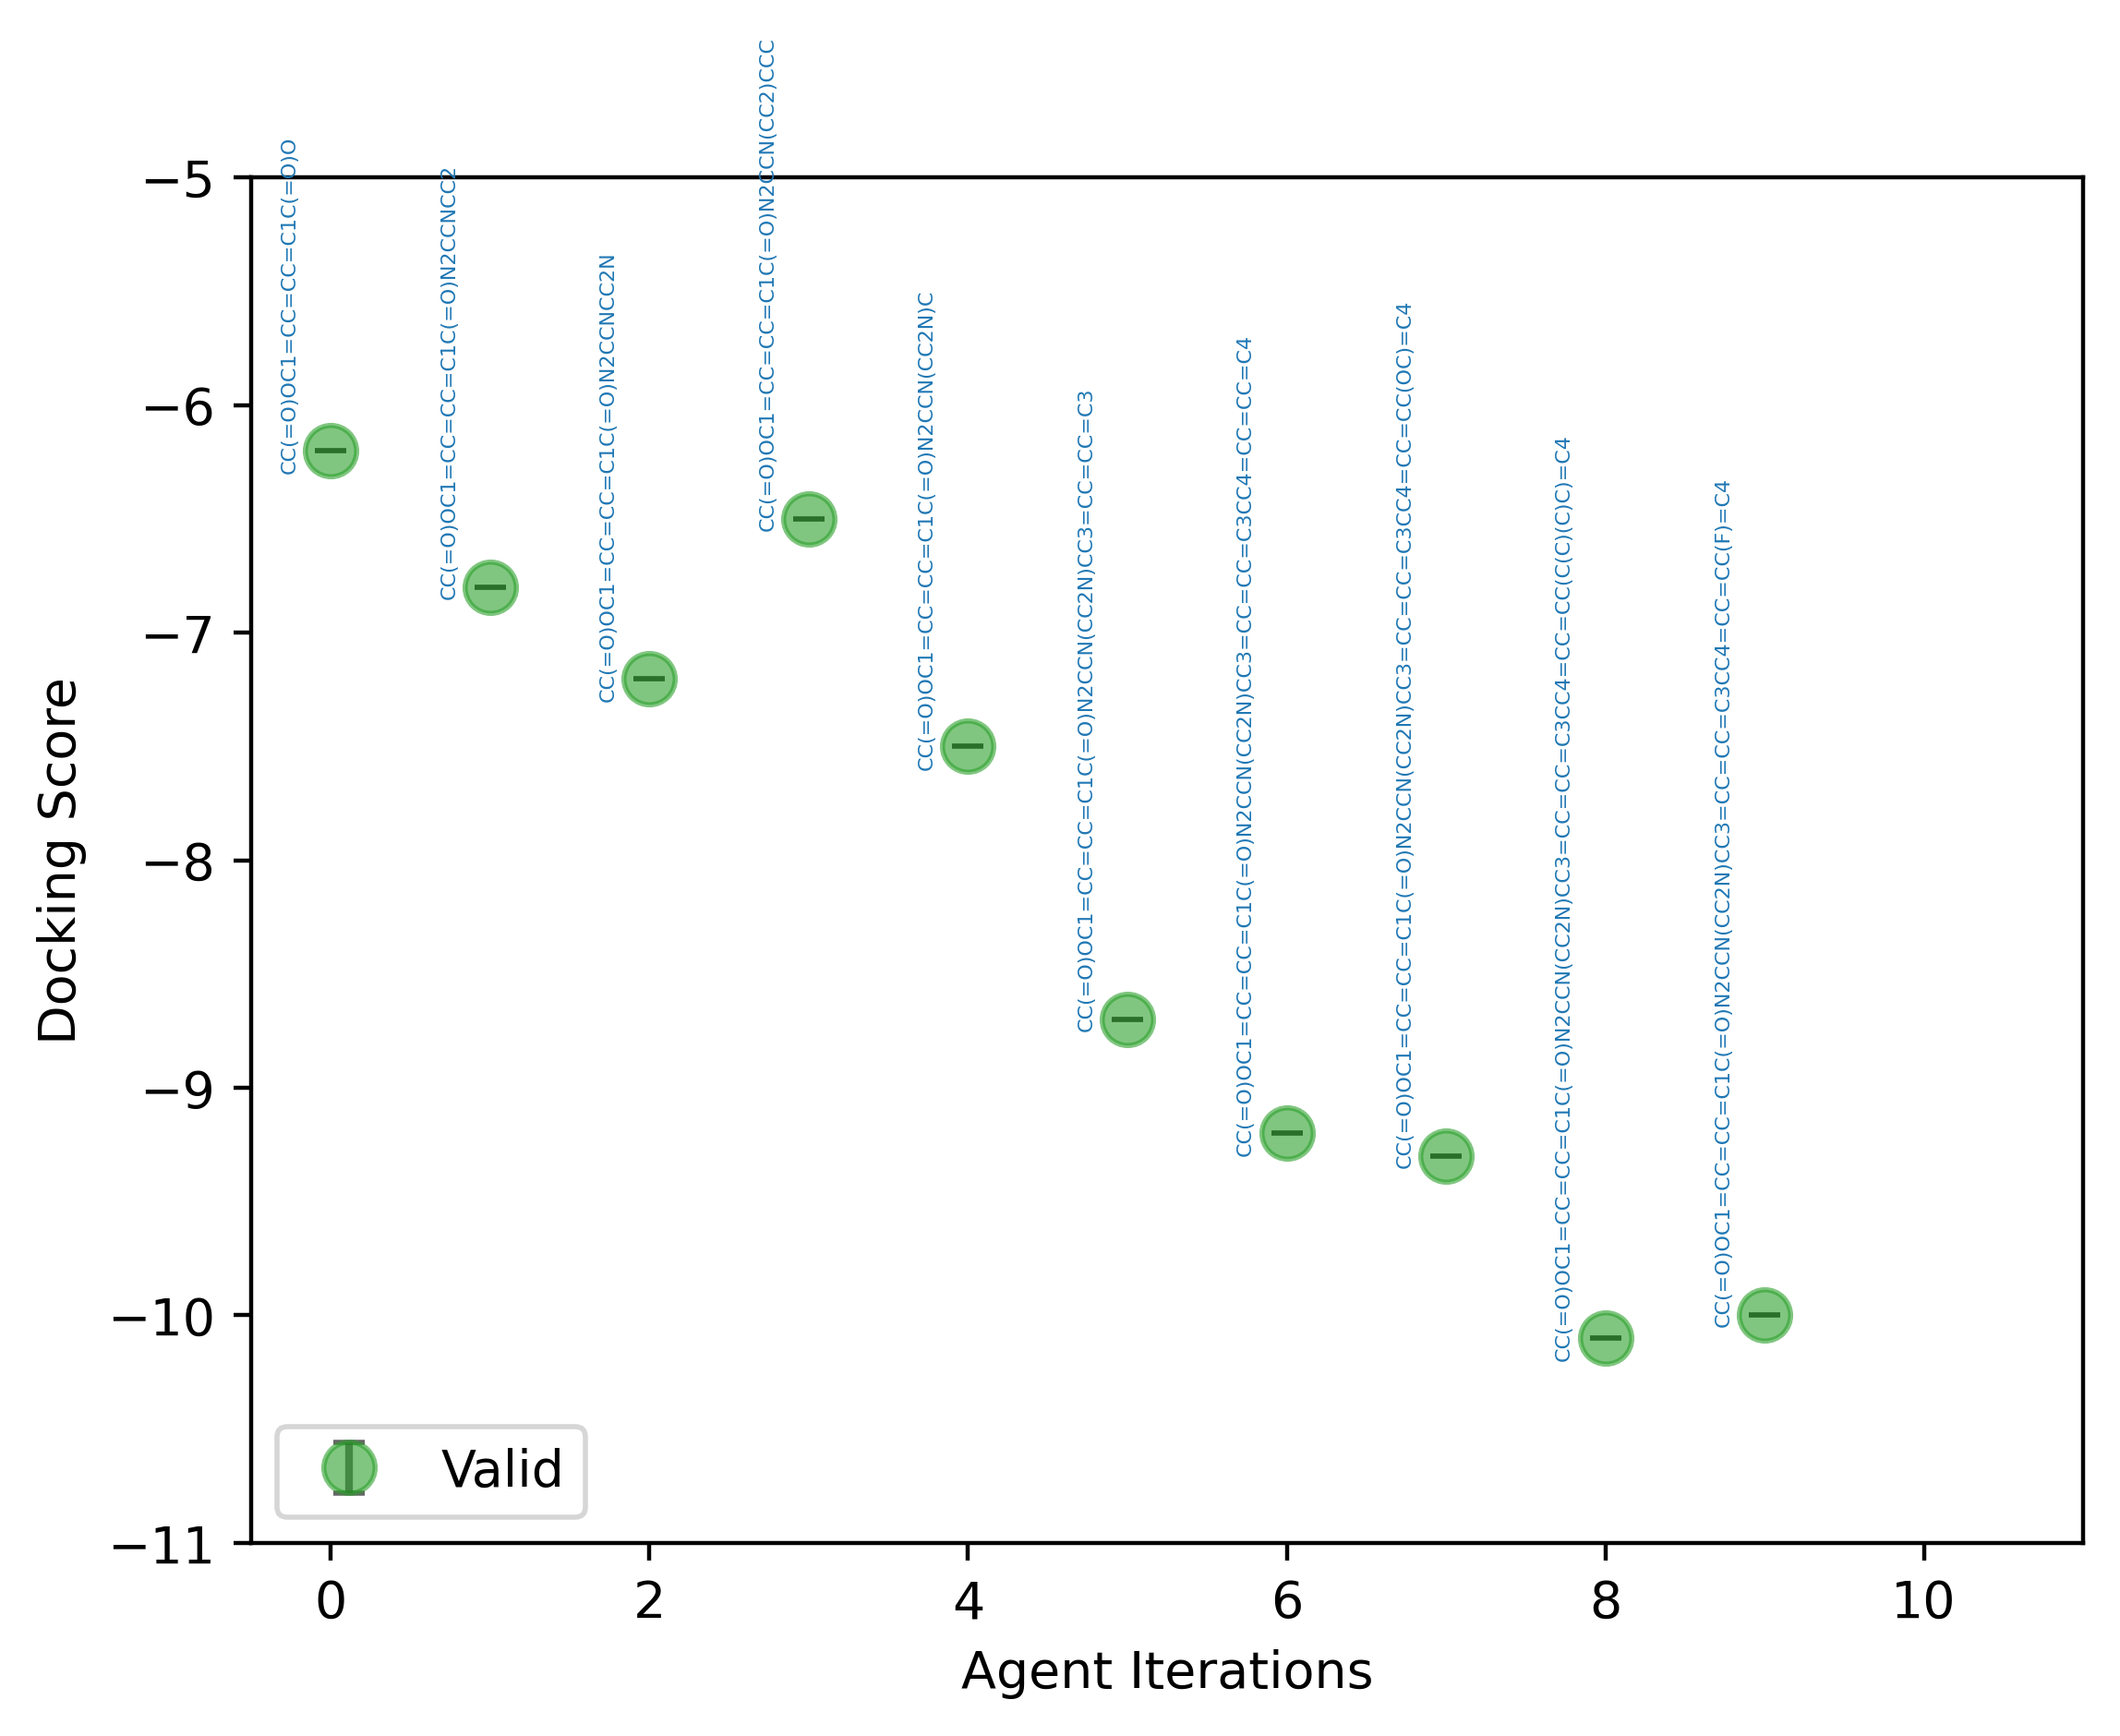

In [62]:
import matplotlib.pyplot as plt

iterations = [item['iteration'] for item in iteration_data]
mean_scores = [item['data']['Docking Score'] for item in iteration_data]
# std_band_gaps = [item['data']['STD CMC'] for item in iteration_data]
smiles_labels = [item['data']['SMILES'] for item in iteration_data]
chemical_feasibilities = [item['data']['Chemical Feasibility'] for item in iteration_data]

plt.figure(dpi=400)

colors = ['C2' if feas == 'Valid' else 'C0' for feas in chemical_feasibilities]

# Plot with error bars and color-coded points
plt.figure(dpi=400)
for i, (x, y, yerr, color) in enumerate(zip(iterations, mean_scores, np.zeros(len(mean_scores)), colors)):
    plt.errorbar(x, y, yerr=yerr, fmt='o', color=color, ecolor='k', capsize=3,
                 linestyle='None', alpha=0.6, markersize=10, label=chemical_feasibilities[i])



vertical_offsets = [(-10 + 5 * (i % 2)) for i in range(len(iterations))]  # Alternating vertical offsets

for x, y, label, offset in zip(iterations, mean_scores, smiles_labels, vertical_offsets):
    plt.text(x-0.2, y + offset/100, label, verticalalignment='bottom', horizontalalignment='right', fontsize=4, color='C0', rotation=90)

ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(), loc="lower left")

plt.xlabel('Agent Iterations')
plt.xlim([-0.5,11])
plt.ylim([-11, -5])
plt.ylabel('Docking Score')

# plt.savefig(f"../results/{iteration_data[0]['data']['SMILES']}_guided.png")

<Figure size 2560x1920 with 0 Axes>

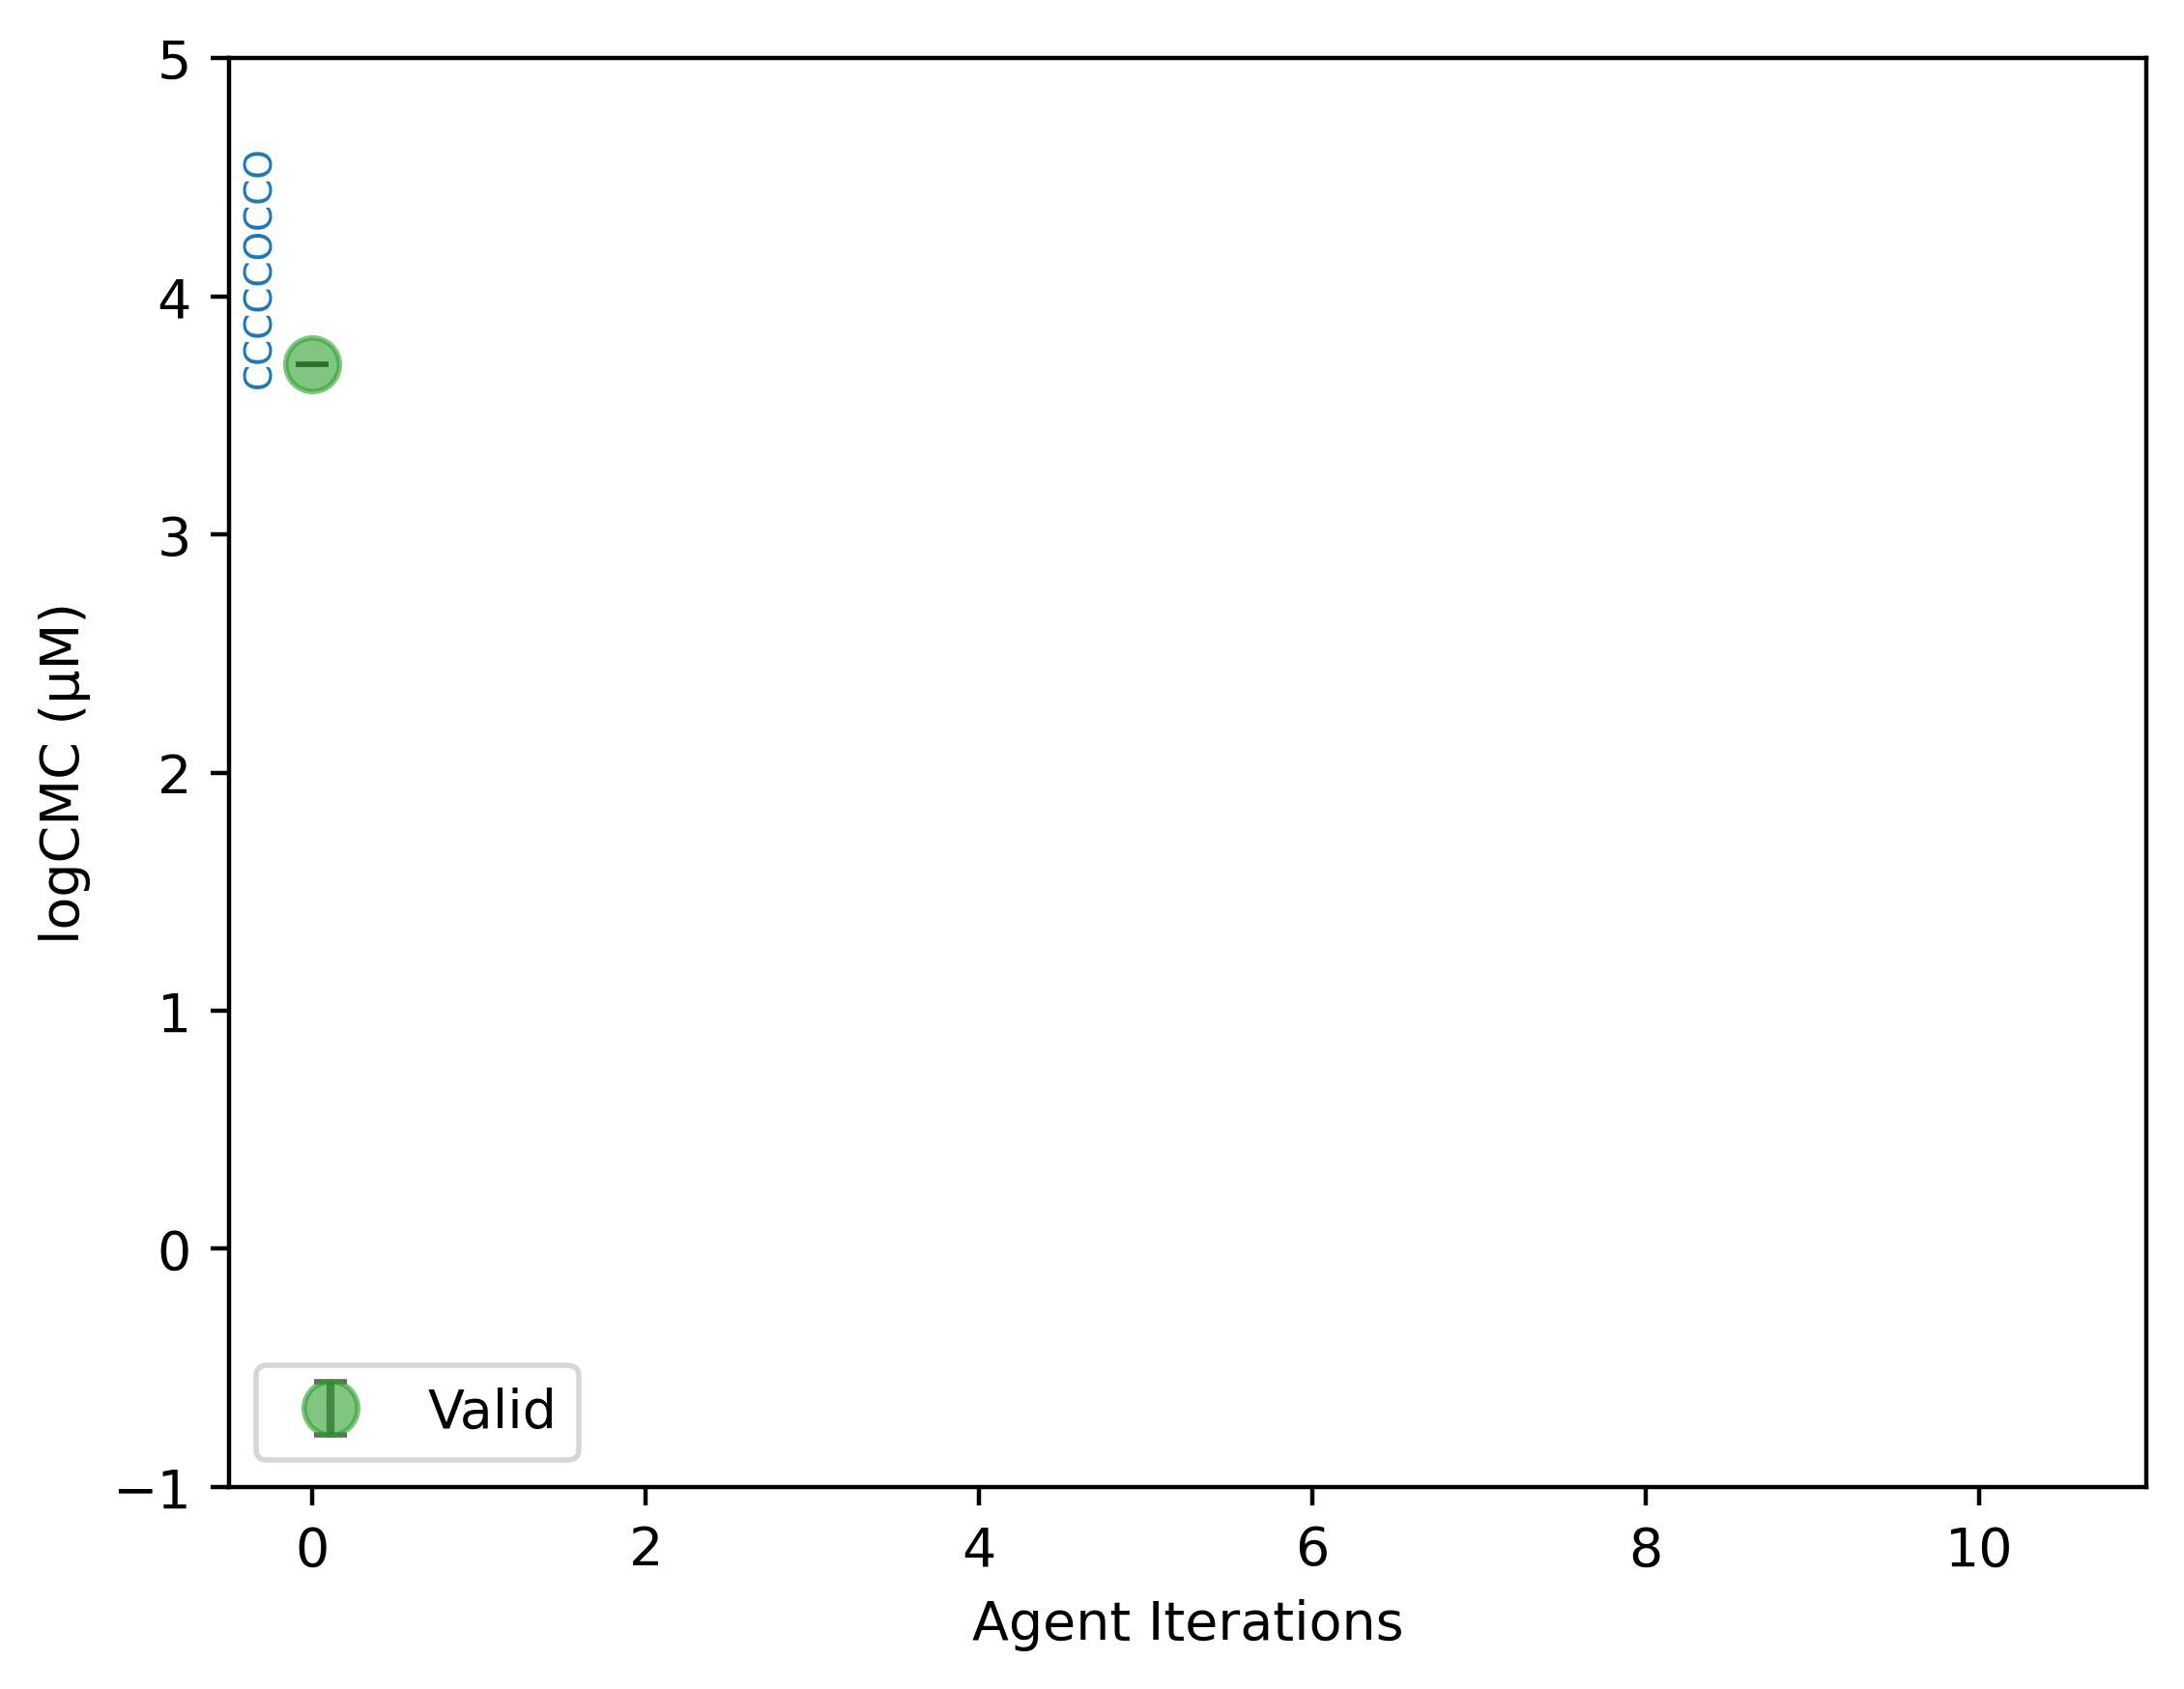

In [162]:
## Plotting sequntially for presentation purposes

# from rdkit import Chem
# from rdkit.Chem import Draw
# import matplotlib.pyplot as plt



# from rdkit.Chem import Draw
# from PIL import Image

# def visualize_smiles(smiles, filename):
#     # Convert SMILES to molecule
#     mol = Chem.MolFromSmiles(smiles)
    
#     # Generate image of the molecule with RDKit and a transparent background
#     img = Draw.MolToImage(mol, size=(1000, 1000), kekulize=True, wedgeBonds=True, options=Draw.DrawingOptions())
    
#     # Convert the image to have a transparent background
#     img = img.convert("RGBA")
#     datas = img.getdata()
#     newData = []
#     for item in datas:
#         # Change all white (also shades of whites)
#         # to transparent
#         if item[0] > 200 and item[1] > 200 and item[2] > 200:
#             newData.append((255, 255, 255, 0))
#         else:
#             newData.append(item)
#     img.putdata(newData)
    
#     # Save the image
#     img.save(filename, "PNG")


# import json


# with open(f"../results/CMC/{initial_surfactant}_guided.json", "r") as json_file:
#     iteration_data = json.load(json_file)

# iterations = [item['iteration'] for item in iteration_data]
# mean_cmcs = [item['data']['CMC'] for item in iteration_data]
# std_cmcs = np.zeros(len(mean_cmcs))
# smiles_labels = [item['data']['SMILES'] for item in iteration_data]
# chemical_feasibilities = [item['data']['Chemical Feasibility'] for item in iteration_data]

# plt.figure(dpi=400)

# colors = ['C2' if feas == 'Valid' else 'C0' for feas in chemical_feasibilities]

# # Plot with error bars and color-coded points

# iter = 0

# plt.figure(dpi=400)
# for i, (x, y, yerr, color) in enumerate(zip(iterations, mean_cmcs, np.zeros(len(mean_cmcs)), colors)):
#     plt.errorbar(x, y, yerr=yerr, fmt='o', color=color, ecolor='k', capsize=3,
#                  linestyle='None', alpha=0.6, markersize=10, label=chemical_feasibilities[i])

#     filename = f'../results/CMC/iter_{i}_{smiles_labels[i]}.png'
#     visualize_smiles(smiles_labels[i], filename)
#     if i == iter:
#         break


# vertical_offsets = [(-10 + 5 * (k % 2)) for k in range(len(iterations))]  # Alternating vertical offsets

# for i, (x, y, label, offset) in enumerate(zip(iterations, mean_cmcs, smiles_labels, vertical_offsets)):
#     plt.text(x-0.2, y + offset/100, label, verticalalignment='bottom', horizontalalignment='right', fontsize=7, color='C0', rotation=90)
#     if i == iter:
#         break

# ax=plt.gca()
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))

# plt.legend(by_label.values(), by_label.keys(), loc="lower left")

# plt.xlabel('Agent Iterations')
# plt.xlim([-0.5,11])
# plt.ylim([-1, 5])
# plt.ylabel('logCMC (μM)')

# plt.savefig(f"../results/CMC/{iter}_{smiles_labels[iter]}_guided.png")

In [125]:
# from rdkit import Chem
# from rdkit.Chem import Draw
# import matplotlib.pyplot as plt



# from rdkit.Chem import Draw
# from PIL import Image

# def visualize_smiles(smiles, filename):
#     # Convert SMILES to molecule
#     mol = Chem.MolFromSmiles(smiles)
    
#     # Generate image of the molecule with RDKit and a transparent background
#     img = Draw.MolToImage(mol, size=(1000, 1000), kekulize=True, wedgeBonds=True, options=Draw.DrawingOptions())
    
#     # Convert the image to have a transparent background
#     img = img.convert("RGBA")
#     datas = img.getdata()
#     newData = []
#     for item in datas:
#         # Change all white (also shades of whites)
#         # to transparent
#         if item[0] > 200 and item[1] > 200 and item[2] > 200:
#             newData.append((255, 255, 255, 0))
#         else:
#             newData.append(item)
#     img.putdata(newData)
    
#     # Save the image
#     img.save(filename, "PNG")

# # Example usage
# filename = f'{initial_surfactant}.png'
# visualize_smiles(initial_surfactant, filename)

In [13]:
# results = agent.invoke(input=f"Look up design guidelines and make changes to the MOF [Co].[O-]C(=O)c1ccncc1 so it will have a higher band gap:\
#             After each change you should first check validity of new SMILES, if valid evaluate the band gap, otherwise revert change and try something else. Do 5 iterations.\n\
#             ")